Notebook putting together concepts from all modeling notebook to construct final model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
import sys
sys.path.append('./lib')
from airbnb_modeling import detect_feature_importance, scale_data, normalize_data, eval_metrics, plot_residuals, plot_predictions
from parse_methods import parse_columns
from airbnb_modeling import detect_interactions, add_interactions, map_variable, plot_rmse_instances,plot_rmse_features, plot_accuracy_instances
#from filename import methodname
#from airbnb_modeling import
#from airbnb_modeling import

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
listings = pd.read_csv('Datasources/listings_augmented/listings_augmented_2018-05-31_V3.csv',low_memory=False)
listings = listings.drop(listings.index[4323:4325])
listings.index = [i for i in range(len(listings))]

In [5]:
#Excluded variables from the featuresExploration notebook
%store -r excluded

In [6]:
cols = [i for i in listings.columns if i not in excluded]
X = listings[cols]

In [7]:
X[X.columns[X.isnull().any()]].isnull().sum()

bathrooms    10
bedrooms      3
beds          4
dtype: int64

In [8]:
X = X.fillna(X.mean())

In [9]:
X = parse_columns(X, ['has_Pets_Allowed','has_Wheelchair_Accessible','has_First_Aid_Kit',
'has_Cat(s)','has_24-Hour_Check-in','uses_jumio','description-Topic0','description-Topic1',
'description-Topic4','description-Topic5','description-Topic6','description-Topic10',
'description-Topic11','description-Topic12','description-Topic13','description-Topic15',
'description-Topic17','description-Topic18','description-Dominant_Topic'])

In [10]:
X = X[[i for i in X.columns if i not in X.filter(regex='enc').columns]]
donotscale = X.filter(regex='bin').columns
cols = [i for i in X.columns if i not in donotscale]
helper_df = pd.DataFrame(preprocessing.normalize(X[cols]), columns = cols)
X_normed = helper_df.merge(X[donotscale], right_index=True, left_index=True)

Now adding new features by taking ratios between features 

In [11]:
other = ['calculated_host_listings_count','extra_people', 'minimum_nights', 'number_of_reviews']
candidates = list(X_normed.filter(regex='event').columns) \
+ list(X_normed.filter(regex='park').columns) + list(X_normed.filter(regex='ocean').columns)\
+ list(X_normed.filter(regex='ratio').columns) + other

In [12]:
import itertools
a = []
for subset in itertools.combinations(candidates, 2):
    a.append(subset)

In [13]:
new = [i for i in a if "bin" not in i[0] and "bin" not in i[1]]

In [14]:
X_ratios = X_normed.copy()
for i in new:
    name = str(i[0]) + '/' + str(i[1]) + '_ratio'
    X_ratios[name] = X_ratios[i[0]]/X_ratios[i[1]]

In [15]:
X_normed[X_normed.columns[X_normed.isnull().any()]].isnull().sum().head()

Series([], dtype: float64)

In [16]:
#Lots of nulls above so dropping columns that have more than 300 nulls and imputing the remaining ones
X_ratios = X_ratios.dropna(axis = 1,thresh = len(X_normed)-300)
X_ratios = X_ratios.replace([np.inf, -np.inf], np.nan)
X_ratios = X_ratios.fillna(X_normed.mean())

In [17]:
y_normed = X_normed['price_y'].fillna(X_normed['price_y'].mean())
X_normed = X_normed[X_normed.columns.drop(X_normed[list(X_normed.filter(regex='price'))])]
X_ratios = X_ratios[X_ratios.columns.drop(X_ratios[list(X_ratios.filter(regex='price'))])]

In [18]:
#Checking that features are clean - output should be True and False
print np.any(np.isnan(X_normed))
print np.all(np.isfinite(X_normed))

False
True


Step1: Simple Model with Linear Regression

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [20]:
print 'Final Number of Features Used: ', len(X_train.columns)

Final Number of Features Used:  138


In [21]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train, y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Using Cross Validation

In [23]:
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [24]:
scores_tree = cross_validate(tree_reg, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [25]:
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)
print '----'
print '----'
print 'Evaluation Metrics for Tree Regression with CV: '
eval_metrics(scores_tree)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8367261556254737
Validation R2 Mean:  0.8141108210063563
Validation R2 STdev:  0.02281127611849167
--
Training RMSE Mean:  0.02517032237136816
Validation RMSE Mean:  0.02671513027489586
Validation RMSE STdev:  6.635340961825122e-05
--
Training MAE Mean:  0.0195095861192613
Validation MAE Mean:  0.02054359368106534
Validation MAE STdev:  0.0009910646197029544
----
----
Evaluation Metrics for Tree Regression with CV: 
Training R2 Mean:  0.9999977308530943
Validation R2 Mean:  0.7280354445655297
Validation R2 STdev:  0.04330628982775324
--
Training RMSE Mean:  9.383340186128148e-05
Validation RMSE Mean:  0.03226550880720896
Validation RMSE STdev:  0.00012090507970467278
--
Training MAE Mean:  4.024771189958336e-05
Validation MAE Mean:  0.02290322333836873
Validation MAE STdev:  0.0010895041071137747


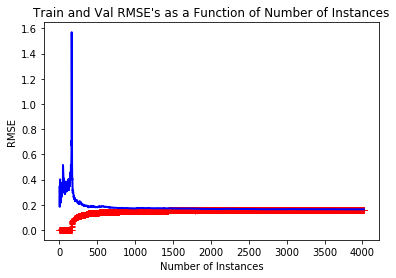

In [26]:
plot_rmse_instances(lin_reg, X_train, y_train)

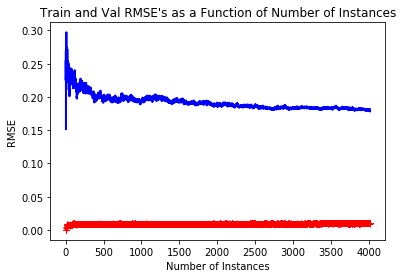

In [27]:
plot_rmse_instances(tree_reg, X_train, y_train)

Do the same for more models and create final plot

Using Nested GridSearch CV with more regressors

In [28]:
sv_reg = SVR()

In [29]:
Cs = np.logspace(-0.1, 10, 30)
param_grid = [
    {'C':Cs, 'epsilon':[i for i in range(1,8,1)], 'kernel':['linear', 'poly'],
    'degree':[2,3,4]},]

In [30]:
gs = GridSearchCV(sv_reg, param_grid, cv=4, scoring='neg_mean_squared_error')

In [31]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'epsilon': [1, 2, 3, 4, 5, 6, 7], 'C': array([7.94328e-01, 1.77123e+00, 3.94959e+00, 8.80699e+00, 1.96383e+01,
       4.37904e+01, 9.76462e+01, 2.17736e+02, 4.85520e+02, 1.08264e+03,
       2.41412e+03, 5.38313e+03, 1.20036e+04, 2.67662e+04, 5.96846e+04,
       1.33088e+05, 2.96766e+05,...29e+08, 2.01117e+09, 4.48460e+09, 1.00000e+10]), 'degree': [2, 3, 4], 'kernel': ['linear', 'poly']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [32]:
scores_sv_reg = cross_validate(gs, X_train, y_train, cv=10, return_train_score=True,
                         scoring='neg_mean_squared_error')

In [33]:
gs_results = gs.cv_results_
print 'Avg Mean Train Score: ', np.sqrt(-gs_results['mean_train_score'].mean())
print 'Avg Mean Val Score: ', np.sqrt(-gs_results['mean_test_score'].mean())

Avg Mean Train Score:  0.08451085066435074
Avg Mean Val Score:  0.08449926935820787


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [34]:
best_model_svr = gs.best_estimator_

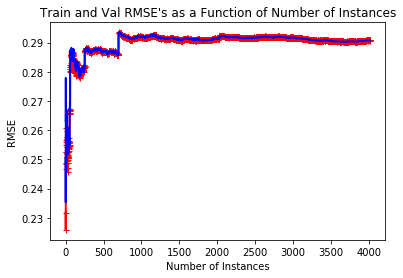

In [35]:
plot_rmse_instances(best_model_svr, X_train, y_train)

K Neighbors Regressors

In [36]:
neigh_reg = KNeighborsRegressor()

In [37]:
param_grid = [
    {'n_neighbors':[2,3,4], 
     'metric':['euclidean']},]
#euclidean: sqrt(sum((x - y)^2)) 
#minkowski: sum(|x - y|^p)^(1/p)

In [38]:
gs = GridSearchCV(neigh_reg, param_grid, cv=3, scoring='neg_mean_squared_error')

In [39]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4], 'metric': ['euclidean']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [40]:
scores_neigh_reg = cross_validate(gs, X_train, y_train, cv=3, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [41]:
gs_results = gs.cv_results_
print 'Avg Mean Train Score: ', np.sqrt(-gs_results['mean_train_score'].mean())
print 'Avg Mean Val Score: ', np.sqrt(-gs_results['mean_test_score'].mean())

Avg Mean Train Score:  0.019983793802404143
Avg Mean Val Score:  0.03003796433855436


In [ ]:
best_model_kneigh = gs.best_estimator_

In [ ]:
plot_rmse_instances(best_model_kneigh, X_train, y_train)

Feature Interactions - We do this in two ways - first we check and add the interactions that increase accuracy beyond an arbitrary threshold (0.02); Then, we just add all interactions

In [ ]:
increments = detect_interactions(X_normed,y_normed, 0.02)

In [ ]:
X_normed_wint = add_interactions(X_normed, increments)

In [ ]:
increments.shape

The above did not return any interactions! That means the interactions are probably not going to make large changes to our models above

In [ ]:
poly = PolynomialFeatures(interaction_only=True)
X_normed_wint = poly.fit_transform(X_normed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normed_wint,y_normed, test_size=0.3, random_state=42)

In [ ]:
lin_reg_intonly = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg_intonly.fit(X_train, y_train)

In [ ]:
scores_lin_intonly = cross_validate(lin_reg_intonly, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [ ]:
print 'Evaluation Metrics for Linear Regression with CV - Interactions Only Added: '
eval_metrics(scores_lin_intonly)

In [ ]:
plot_rmse_instances(lin_reg_intonly, X_train, y_train)

Let's also try adding quadratic terms to the normalized dataset to see if nonlinaer regression might help

In [ ]:
poly = PolynomialFeatures(2)
X_normed_quad = poly.fit_transform(X_normed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normed_quad,y_normed, test_size=0.3, random_state=42)

In [ ]:
quad_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
quad_reg.fit(X_train, y_train)

In [ ]:
scores_quad = cross_validate(quad_reg, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [ ]:
print 'Evaluation Metrics for Linear Regression with CV - Interactions Only Added: '
eval_metrics(scores_quad)

In [ ]:
plot_rmse_instances(quad_reg, X_train, y_train)

Finally, we pick the most promising model and add ratios features. We rerun it and see how the new features make any changes

In [ ]:
#X_ratios

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios,y_normed, test_size=0.3, random_state=42)

Feature Selection - We use the most promising model above to continue from now on

In [ ]:
estimator = #insert best model here
selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_normed, y_normed)

In [ ]:
print("Optimal number of features : %d" % selector.n_features_)

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

In [ ]:
X_new = selector.transform(X_normed)

All features have equally important ranking!

In [ ]:
selector.ranking_

Now let's rerun our best model so far and evaluate changes to model metrics resulting from removing unneeded features

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_new, y_normed, test_size=0.3, random_state=42)

In [ ]:
model = model(fit_intercept=True, normalize=False)
lin_reg.fit(X_train,y_train)
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)

The Validation Metrics have all (slightly) improved!

Now we rebuild the model only with the important features i.e. number of features where val error is lowest

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_ratios, y_normed, test_size=0.3, random_state=42)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_normed.columns, selector.ranking_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RFECV_Ranking'})
importances = importances.sort_values(by='RFECV_Ranking')
importances.head()

Let's pick only interaction features that minimize CV RMSE by feeding the new data into RFECV

In [ ]:
estimator = best_model(fit_intercept=True, normalize=False)
selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train_int, y_train)
print("Optimal number of features : %d" % selector.n_features_)

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

Is it worth adding creating a new model with only important features?

In [ ]:
#X_new = selector.transform(X_normed)
#Add rest if needed

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, selector.ranking_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RFECV_Ranking'})
importances = importances.sort_values(by='RFECV_Ranking', ascending=False)

In [ ]:
best_features = list(importances.head(selector.n_features_).index)

In [ ]:
plot_rmse_features(model, X_train_int, y_train, best_features)

In [ ]:
#only do this after have done decision tree RFECV
#plot_rmse_features(tree_reg, X_normed, y_normed,X_normed.columns)

Finally, let's see how either of the two models performs against our Test Set

In [ ]:
test_predictions_lin_reg = lin_reg.predict(X_test)
test_predictions_tree_reg = tree_reg.predict(X_test)
test_predictions_best_model_svr = best_model_svr.predict(X_test)
test_predictions_best_model_kneigh = best_model_kneigh.predict(X_test)
test_predictions_lin_reg_intonly = lin_reg_intonly.predict(X_test)
test_predictions_quad_reg = quad_reg.predict(X_test)

In [ ]:
print 'Evaluation Metrics for Linear Regression'
print 'Test R2: ',r2_score(y_test, test_predictions_lin_reg)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_lin_reg))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_lin_reg)
plot_residuals(X_test,y_test,test_predictions_lin_reg)
map_variable(y_test-test_predictions_lin_reg, listings)

In [ ]:
print 'Evaluation Metrics for Decision Tree Regression'
print 'Test R2: ',r2_score(y_test, test_predictions_tree_reg)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_tree_reg))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_tree_reg)
plot_residuals(X_test,y_test,test_predictions_tree_reg)
map_variable(y_test-test_predictions_tree_reg, listings)

In [ ]:
print 'Evaluation Metrics for Support Vector Regression'
print 'Test R2: ',r2_score(y_test, test_predictions_best_model_svr)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_best_model_svr))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_best_model_svr)
plot_residuals(X_test,y_test,test_predictions_best_model_svr)
map_variable(y_test-test_predictions_best_model_svr, listings)

In [ ]:
print 'Evaluation Metrics for K Nearest Neighbors Regression'
print 'Test R2: ',r2_score(y_test, test_predictions_best_model_kneigh)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_best_model_kneigh))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_best_model_kneigh)
plot_residuals(X_test,y_test,test_predictions_best_model_kneigh)
map_variable(y_test-test_predictions_best_model_kneigh, listings)

In [ ]:
print 'Evaluation Metrics for Linear Regression with Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions_lin_reg_intonly)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_lin_reg_intonly))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_lin_reg_intonly)
plot_residuals(X_test,y_test,test_predictions_lin_reg_intonly)
map_variable(y_test-test_predictions_lin_reg_intonly, listings)

In [ ]:
print 'Evaluation Metrics for Quadratic Regression without Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions_quad_reg)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_quad_reg))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_quad_reg)
plot_residuals(X_test,y_test,test_predictions_quad_reg)
map_variable(y_test-test_predictions_quad_reg, listings)

Best model with Ratios

In [ ]:
print 'Evaluation Metrics for Quadratic Regression without Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions_quad_reg)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_quad_reg))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_quad_reg)
plot_residuals(X_test,y_test,test_predictions_quad_reg)
map_variable(y_test-test_predictions_quad_reg, listings)

Comment about results with interactions:

Let's introduce some degree of regularization to see if we can decrease validation RMSE even further

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [ ]:
lasso = linear_model.Lasso()

In [ ]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [ ]:
gs = GridSearchCV(lasso, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
gs.best_params_

In [ ]:
best_model = gs.best_estimator_

In [ ]:
#Comparing Model Coefficients by using best model parameters obtained above

In [ ]:
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [ ]:
test_predictions = best_model.predict(X_test)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Lasso_Coef'})
importances = importances.sort_values(by='Lasso_Coef', ascending=False)

In [ ]:
importances[importances['Lasso_Coef']>0]

Now trying Ridge:

In [ ]:
ridge = linear_model.Ridge()

In [ ]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [ ]:
gs = GridSearchCV(ridge, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
gs.best_params_

In [ ]:
#Comparing Model Coefficients by using best model parameters obtained above

In [ ]:
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Ridge_Coef'})
importances = importances.sort_values(by='Ridge_Coef', ascending=False)

In [ ]:
importances[importances['Ridge_Coef']>0]

Now Using ElasticNet

In [ ]:
en = linear_model.ElasticNet(random_state=0)

In [ ]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [ ]:
gs = GridSearchCV(en, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
gs.best_params_

In [ ]:
#Comparing Model Coefficients by using best model parameters obtained above

In [ ]:
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'EN_Coef'})
importances = importances.sort_values(by='EN_Coef', ascending=False)

In [ ]:
importances[importances['EN_Coef']>0]

Ensembles

RandomForest Regression

The Random Forest Regressor Does very well on both Training and Validation - a promising model!

In [ ]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8,10,12]},
    {'bootstrap': [True,False], 'n_estimators':[3,10], 'max_features':[2,4,6,8,10,12]},
]

In [ ]:
new_for_reg = RandomForestRegressor()

In [ ]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs_results = gs.cv_results_

In [ ]:
print 'Avg Mean Train Score: ', -gs_results['mean_train_score'].mean()
print 'Avg Mean Val Score: ', -gs_results['mean_test_score'].mean()

In [ ]:
imp = gs.best_estimator_.feature_importances_

In [ ]:
from operator import itemgetter
imp = pd.DataFrame(sorted(zip(X.columns, imp),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance'])

In [ ]:
imp.sort_values(by='Importance', ascending=False).head()

Now testing with Test Dataset:

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

Try more ensembles e.g. adaboost

Bagging Regressor

In [ ]:
br = BaggingRegressor()

In [ ]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[i for i in range(10,80,10)], 'bootstrap': [True,False]},
]

In [ ]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)

In [ ]:
print gs.best_params_
print gs.best_estimator_
gs_results = gs.cv_results_

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
plot_residuals(X_test,y_test,test_predictions)

In [ ]:
plot_predictions(y_test,test_predictions)